# Solving linear systems of equations using HHL and its Qiskit implementation

In this tutorial, we introduce the HHL algorithm, derive the circuit, and implement it using Qiskit. We show how to run the HHL on a simulator and on a five qubit device.

## Contents
1. [Introduction](#introduction)
2. [The HHL algorithm](#hhlalg)
    1. [Some mathematical background](#mathbackground)
    2. [Description of the HHL](#hhldescription)
    3. [Quantum Phase Estimation (QPE) within HHL](#qpe)
    4. [Non-exact QPE](#qpe2)
3. [Example 1: 4-qubit HHL](#example1)
4. [Qiskit Implementation](#implementation)
    1. [Running HHL on a simulator: general method](#implementationsim)
    2. [Running HHL on a real quantum device: optimised example](#implementationdev)
5. [Problems](#problems)
6. [References](#references)

## 1. Introduction <a id='introduction'></a>

Systems of linear equations arise naturally in many real-life applications in a wide range of areas, such as in the solution of Partial Differential Equations, the calibration of financial models, fluid simulation or numerical field calculation. The problem can be defined as, given a matrix $A\in\mathbb{C}^{N\times N}$ and a vector $\vec{b}\in\mathbb{C}^{N}$, find $\vec{x}\in\mathbb{C}^{N}$ satisfying $A\vec{x}=\vec{b}$

For example, take $N=2$, 

$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix},\quad \vec{x}=\begin{pmatrix} x_{1}\\ x_{2}\end{pmatrix}\quad \text{and} \quad \vec{b}=\begin{pmatrix}1 \\ 0\end{pmatrix}$$

Then the problem can also be written as find $x_{1}, x_{2}\in\mathbb{C}$ such that
$$\begin{cases}x_{1} - \frac{x_{2}}{3} = 1 \\ -\frac{x_{1}}{3} + x_{2} = 0\end{cases} $$

A system of linear equations is called $s$-sparse if $A$ has at most $s$ non-zero entries per row or column. Solving an $s$-sparse system of size $N$ with a classical computer requires $\mathcal{ O }(Ns\kappa\log(1/\epsilon))$ running time using the conjugate gradient method <sup>[1](#conjgrad)</sup>. Here $\kappa$ denotes the condition number of the system and $\epsilon$ the accuracy of the approximation.

The HHL is a quantum algorithm to estimate a function of the solution with running time complexity of $\mathcal{ O }(\log(N)s^{2}\kappa^{2}/\epsilon)$<sup>[2](#hhl)</sup> when $A$ is a Hermitian matrix under the assumptions of efficient oracles for loading the data, Hamiltonian simulation and computing a function of the solution. This is an exponential speed up in the size of the system, however one crucial remark to keep in mind is that the classical algorithm returns the full solution, while the HHL can only approximate functions of the solution vector.

## 2. The HHL algorithm<a id='hhlalg'></a>

### A. Some mathematical background<a id='mathbackground'></a>
The first step towards solving a system of linear equations with a quantum computer is to encode the problem in the quantum language. By rescaling the system, we can assume $\vec{b}$ and $\vec{x}$ to be normalised and map them to the respective quantum states $|b\rangle$ and $|x\rangle$. Usually the mapping used is such that $i^{th}$ component of $\vec{b}$ (resp. $\vec{x}$) corresponds to the amplitude of the $i^{th}$ basis state of the quantum state $|b\rangle$ (resp. $|x\rangle$). From now on, we will focus on the rescaled problem

$$ A|x\rangle=|b\rangle$$

Since $A$ is Hermitian, it has a spectral decomposition
$$
A=\sum_{j=0}^{N-1}\lambda_{j}|u_{j}\rangle\langle u_{j}|,\quad \lambda_{j}\in\mathbb{ R }
$$
where $|u_{j}\rangle$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$. Then,
$$
A^{-1}=\sum_{j=0}^{N-1}\lambda_{j}^{-1}|u_{j}\rangle\langle u_{j}|
$$
and the right hand side of the system can be written in the eigenbasis of $A$ as
$$
|b\rangle=\sum_{j=0}^{N-1}b_{j}|u_{j}\rangle,\quad b_{j}\in\mathbb{ C }
$$
It is useful to keep in mind that the goal of the HHL is to exit the algorithm with the readout register in the state
$$
|x\rangle=A^{-1}|b\rangle=\sum_{j=0}^{N-1}\lambda_{j}^{-1}b_{j}|u_{j}\rangle
$$
Note that here we already have an implicit normalisation constant since we are talking about a quantum state.

### B. Description of the HHL algorithm <a id='hhldescription'></a>

The algorithm uses three quantum registers, all of them set to $|0\rangle $ at the beginning of the algorithm. One register, which we will denote with the subindex $n_{l}$, is used to store a binary representation of the eigenvalues of $A$. A second register, denoted by $n_{b}$, contains the vector solution, and from now on $N=2^{n_{b}}$. There is an extra register, for the auxiliary qubits. These are qubits used as intermediate steps in the individual computations but will be ignored in the following description since they are set to $|0\rangle $ at the beginning of each computation and restored back to the $|0\rangle $ state at the end of the individual operation.

The following is an outline of the HHL algorithm with a high-level drawing of the corresponding circuit. For simplicity all computations are assumed to be exact in the ensuing description, and a more detailed explanation of the non-exact case is given in Section [2.D.](#qpe2).

<img src="images/hhlcircuit.png" width = "75%" height = "75%">

1.  Load the data $|b\rangle\in\mathbb{ C }^{N}$. That is, perform the transformation  

    $$ |0\rangle _{n_{b}} \mapsto |b\rangle _{n_{b}} $$  
    
2. Apply Quantum Phase Estimation (QPE) with  

	$$
	U = e ^ { i A t } := \sum _{j=0}^{N-1}e ^ { i \lambda _ { j } t } |u_{j}\rangle\langle u_{j}|
	$$  
    
	The quantum state of the register expressed in the eigenbasis of $A$ is now  
    
	$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}
	$$  
    
    where $|\lambda _ {j }\rangle_{n_{l}}$ is the $n_{l}$-bit binary representation of $\lambda _ {j }$.  
    
3. Add an auxiliary qubit and apply a rotation conditioned on $|\lambda_{ j }\rangle$,  

	$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac { C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right)
	$$  
    
	where $C$ is a normalisation constant, and, as expressed in the current form above, should be less than the smallest eigenvalue $\lambda_{min}$ in magnitude, i.e., $|C| < \lambda_{min}$.  
    
4. Apply QPE$^{\dagger}$. Ignoring possible errors from QPE, this results in  

	$$
	\sum_{j=0}^{N-1} b _ { j } |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} \left( \sqrt { 1 - \frac {C^{2}  } { \lambda _ { j } ^ { 2 } } } |0\rangle + \frac { C } { \lambda _ { j } } |1\rangle \right)
	$$  
    
5. Measure the auxiliary qubit in the computational basis. If the outcome is $1$, the register is in the post-measurement state  

	$$
	\left( \sqrt { \frac { 1 } { \sum_{j=0}^{N-1} \left| b _ { j } \right| ^ { 2 } / \left| \lambda _ { j } \right| ^ { 2 } } } \right) \sum _{j=0}^{N-1} \frac{b _ { j }}{\lambda _ { j }} |0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
	$$  
    
	which up to a normalisation factor corresponds to the solution.

6. Apply an observable $M$ to calculate $F(x):=\langle x|M|x\rangle$.  


### C. Quantum Phase Estimation (QPE) within HHL <a id='qpe'></a>

Quantum Phase Estimation is described in more detail in Chapter 3. However, since this quantum procedure is at the core of the HHL algorithm, we recall here the definition. Roughly speaking, it is a quantum algorithm which, given a unitary $U$ with eigenvector $|\psi\rangle_{m}$ and eigenvalue $e^{2\pi i\theta}$, finds $\theta$. We can formally define this as follows.

**Definition:** Let $U\in\mathbb{ C }^{2^{m}\times 2^{m}}$ be unitary and let $|\psi\rangle_{m}\in\mathbb{ C }^{2^{m}}$ be one of its eigenvectors with respective eigenvalue $e^{2\pi i\theta}$. The **Quantum Phase Estimation** algorithm, abbreviated **QPE**, takes as inputs the unitary gate for $U$ and the state $|0\rangle_{n}|\psi\rangle_{m}$ and returns the state $|\tilde{\theta}\rangle_{n}|\psi\rangle_{m}$. Here $\tilde{\theta}$ denotes a binary approximation to $2^{n}\theta$ and the $n$ subscript denotes it has been truncated to $n$ digits.	
$$
\operatorname { QPE } ( U , |0\rangle_{n}|\psi\rangle_{m} ) = |\tilde{\theta}\rangle_{n}|\psi\rangle_{m}
$$

For the HHL we will use QPE with $U = e ^ { i A t }$, where $A$ is the matrix associated to the system we want to solve. In this case, 
$$
e ^ { i A t } = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}|u_{j}\rangle\langle u_{j}|
$$
Then, for the eigenvector $|u_{j}\rangle_{n_{b}}$, which has eigenvalue $e ^ { i \lambda _ { j } t }$, QPE will output $|\tilde{\lambda }_ { j }\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}$. Where $\tilde{\lambda }_ { j }$ represents an $n_{l}$-bit binary approximation to $2^{n_l}\frac{\lambda_ { j }t}{2\pi}$. Therefore, if each $\lambda_{j}$ can be exactly represented with $n_{l}$ bits,
$$
\operatorname { QPE } ( e ^ { i A t } , \sum_{j=0}^{N-1}b_{j}|0\rangle_{n_{l}}|u_{j}\rangle_{n_{b}} ) = \sum_{j=0}^{N-1}b_{j}|\lambda_{j}\rangle_{n_{l}}|u_{j}\rangle_{n_{b}}
$$

### D. Non-exact QPE <a id='qpe2'></a>

In reality, the quantum state of the register after applying QPE to the initial state is
$$
\sum _ { j=0 }^{N-1} b _ { j } \left( \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } |l\rangle_{n_{l}} \right)|u_{j}\rangle_{n_{b}}
$$
where
$$
\alpha _ { l | j } = \frac { 1 } { 2 ^ { n_{l} } } \sum _ { k = 0 } ^ { 2^{n_{l}}- 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l } { 2 ^ { n_{l} } } \right) } \right) ^ { k }
$$

Denote by $\tilde{\lambda_{j}}$ the best $n_{l}$-bit approximation to $\lambda_{j}$, $1\leq j\leq N$. Then we can relabel the $n_{l}$-register so that $\alpha _ { l | j }$ denotes the amplitude of $|l + \tilde { \lambda } _ { j } \rangle_{n_{l}}$. So now,
$$
\alpha _ { l | j } : = \frac { 1 } { 2 ^ { n_{l}} } \sum _ { k = 0 } ^ { 2 ^ { n_{l} } - 1 } \left( e ^ { 2 \pi i \left( \frac { \lambda _ { j } t } { 2 \pi } - \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } } \right) } \right) ^ { k }
$$
If each $\frac { \lambda _ { j } t } { 2 \pi }$ can be represented exactly with $n_{l}$ binary bits, then $\frac { \lambda _ { j } t } { 2 \pi }=\frac { \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }$ $\forall j$. Therefore in this case $\forall j$, $1\leq j \leq N$, it holds that $\alpha _ { 0 | j } = 1$ and $\alpha _ { l | j } = 0 \quad \forall l \neq 0$. Only in this case we can write that the state of the register after QPE is 
$$
	\sum_{j=0}^{N-1} b _ { j } |\lambda _ {j }\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}
$$
Otherwise, $|\alpha _ { l | j }|$ is large if and only if $\frac { \lambda _ { j } t } { 2 \pi } \approx \frac { l + \tilde { \lambda } _ { j } } { 2 ^ { n_{l} } }$ and the state of the register is
$$
\sum _ { j=0 }^{N-1}  \sum _ { l = 0 } ^ { 2 ^ { n_{l} } - 1 } \alpha _ { l | j } b _ { j }|l\rangle_{n_{l}} |u_{j}\rangle_{n_{b}}
$$

## 3. Example: 4-qubit HHL<a id='example1'></a>

Let's take the small example from the introduction to illustrate the algorithm. That is,
$$A = \begin{pmatrix}1 & -1/3\\-1/3 & 1 \end{pmatrix}\quad \text{and} \quad |b\rangle=\begin{pmatrix}1 \\ 0\end{pmatrix}$$

We will use $n_{b}=1$ qubit to represent $|b\rangle$, and later the solution $|x\rangle$, $n_{l}=2$ qubits to store the binary representation of the eigenvalues and $1$ auxiliary qubit to store whether the conditioned rotation, hence the algorithm, was successful.

For the purpose of illustrating the algorithm, we will cheat a bit and calculate the eigenvalues of $A$ to be able to choose $t$ to obtain an exact binary representation of the rescaled eigenvalues in the $n_{l}$-register. However, keep in mind that for the HHL algorithm implementation one does not need previous knowledge of the eigenvalues. Having said that, a short calculation will give
$$\lambda_{1} = 2/3\quad\text{and}\quad\lambda_{2}=4/3$$

Recall from the previous section that the QPE will output an $n_{l}$-bit ($2$-bit in this case) binary approximation to $\frac{\lambda_ { j }t}{2\pi}$. Therefore, if we set 
$$t=2\pi\cdot \frac{3}{8}$$
the QPE will give a $2$-bit binary approximation to
$$\frac{\lambda_ { 1 }t}{2\pi} = 1/4\quad\text{and}\quad\frac{\lambda_ { 2 }t}{2\pi}=1/2$$
which is, respectively,
$$|01\rangle_{n_{l}}\quad\text{and}\quad|10\rangle_{n_{l}}$$

The eigenvectors are, respectively,
$$|u_{1}\rangle=\begin{pmatrix}1 \\ -1\end{pmatrix}\quad\text{and}\quad|u_{2}\rangle=\begin{pmatrix}1 \\ 1\end{pmatrix}$$
Again, keep in mind that one does not need to compute the eigenvectors for the HHL implementation. In fact, a general Hermitian matrix $A$ of dimension $N$ can have up to $N$ different eigenvalues, therefore calculating them would take $\mathcal{O}(N)$ time and the quantum advantage would be lost.

We can then write $|b\rangle$ in the eigenbasis of $A$ as
$$|b\rangle _{n_{b}}=\sum_{j=1}^{2}\frac{1}{\sqrt{2}}|u_{j}\rangle _{n_{b}}$$

Now we are ready to go through the different steps of the HHL algorithm. 

1. State preparation in this example is trivial since $|b\rangle=|0\rangle$.
2. Applying QPE will yield
$$
\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle
$$
3. Conditioned rotation with $C=1/8$ that is less than the smallest (rescaled) eigenvalue of $\frac {1} {4}$. Note, the contant $C$ here needs to be chosen such that it is less than the smallest (rescaled) eigenvalue of $\frac {1} {4}$ but as large as possible so that when the auxiliary qubit is measured, the probabilit of it being in the state $|1>$ is large.
$$\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2}  } {(1/4)^{2} } } |0\rangle + \frac { 1/8 } { 1/4 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { (1/8)^{2}  } {(1/2)^{2} } } |0\rangle + \frac { 1/8 } { 1/2 } |1\rangle \right)
$$
$$
=\frac{1}{\sqrt{2}}|01\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 1  } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|10\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 1  } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right)
$$
4. After applying QPE$^{\dagger}$ the quantum computer is in the state
$$
\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\left( \sqrt { 1 - \frac { 1  } {4 } } |0\rangle + \frac { 1 } { 2 } |1\rangle \right) + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\left( \sqrt { 1 - \frac { 1  } {16 } } |0\rangle + \frac { 1 } { 4 } |1\rangle \right)
$$
5. On outcome $1$ when measuring the auxiliary qubit, the state is 
$$
\frac{\frac{1}{\sqrt{2}}|00\rangle|u_{1}\rangle\frac { 1 } { 2 } |1\rangle + \frac{1}{\sqrt{2}}|00\rangle|u_{2}\rangle\frac { 1 } { 4 } |1\rangle}{\sqrt{5/32}}
$$
A quick calculation shows that
$$
\frac{\frac{1}{2\sqrt{2}}|u_{1}\rangle+ \frac{1}{4\sqrt{2}}|u_{2}\rangle}{\sqrt{5/32}} = \frac{|x\rangle}{||x||}
$$
6. Without using extra gates, we can compute the norm of $|x\rangle$: it is the probability of measuring $1$ in the auxiliary qubit from the previous step.
$$
P(|1\rangle) = \left(\frac{1}{2\sqrt{2}}\right)^{2} + \left(\frac{1}{4\sqrt{2}}\right)^{2} = \frac{5}{32} = ||x||^{2}
$$



## 4. Qiskit Implementation<a id='implementation'></a>

Now that we have analytically solved the problem from the example we are going to use it to illustrate how to run the HHL on a quantum simulator and on the real hardware. For the quantum simulator, Qiskit Aqua already provides an implementation of the HHL algorithm requiring the matrix $A$ and $|b\rangle$ as basic inputs. The main advantage is that it can take a general Hermitian matrix and an arbitrary initial state as inputs. This means that the algorithm is designed for a general purpose and does not optimise the circuit for a particular problem, which is problematic if the goal is to run the circuit on the existing real hardware. At the time of writing, the existing quantum computers are noisy and can only run small circuits. Therefore, in Section [4.B.](#implementationdev) we will see an optimised circuit that can be used for a class of problems to which our example belongs and mention the existing procedures to deal with noise in quantum computers.

## A. Running HHL on a simulator: general method<a id='implementationsim'></a>

To run the HHL algorithm provided by Qiskit Aqua we just need to import the right modules and set the parameters as follows. In the worked out example we set the time of the Hamiltonian simulation to $t=2\pi\cdot \frac{3}{8}$, however we will run the simulation without setting this parameter to show that knowledge of the eigenvalues is not required. Nonetheless, if the matrix has some structure it might be possible to obtain information about the eigenvalues and use it to choose a suitable $t$ and improve the accuracy of the solution returned by the HHL. As an exercise to see this, run the algorithm setting the time to $t=2\pi\cdot \frac{3}{8}$. If done correctly, the fidelity of the solution should be $1$.

In [1]:
from qiskit import Aer, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np

In [2]:
def create_eigs(matrix, num_auxiliary, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_auxiliary += 1
        ne_qfts = [QFT(num_auxiliary - 1), QFT(num_auxiliary - 1).inverse()]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_auxiliary).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_auxiliary,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None,  # This is t, can set to: np.pi*3/4
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

The following function will be used to calculate the fidelity of solution returned by the HHL algorithm.

In [3]:
def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    print("Fidelity:\t\t %f" % fidelity)

In [4]:
matrix = [[1, -1/3], [-1/3, 1]]
vector = [1, 0]

In [5]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
eigs = create_eigs(matrix, 3, 50, False)
num_q, num_a = eigs.get_register_sizes()

# Initialize initial state module
init_state = Custom(num_q, state_vector=vector)

# Initialize reciprocal rotation module
reci = LookupRotation(negative_evals=eigs._negative_evals, evo_time=eigs._evo_time)

algo = HHL(matrix, vector, truncate_powerdim, truncate_hermitian, eigs,
           init_state, reci, num_q, num_a, orig_size)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operators/legacy/op_converter.py:90: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.aqua_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  num_processes=aqua_globals.num_processes)
/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/initial_states/custom.py:79: DeprecationWarning: The Custom class is deprecated as of Aqua 0.9 and will be removed no earlier than 3 months after the release date. Instead, all algorithms and circuits 

The reason to choose $t=2\pi\cdot \frac{3}{8}$ was so that the rescaled eigenvalues could be represented exactly with $2$ binary digits. Since now this is not the case, the representation will be approximate, hence QPE not exact and the returned solution will be an approximation.

In [6]:
result = algo.run(QuantumInstance(Aer.get_backend('statevector_simulator')))
print("Solution:\t\t", np.round(result['solution'], 5))

result_ref = NumPyLSsolver(matrix, vector).run()
print("Classical Solution:\t", np.round(result_ref['solution'], 5))

print("Probability:\t\t %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/initial_states/custom.py:151: DeprecationWarning: The StateVectorCircuit class is deprecated as of Qiskit Aqua 0.9.0 and will be removed no earlier than 3 months after the release. If you need to initialize a circuit, use the QuantumCircuit.initialize or QuantumCircuit.isometry methods. For a parameterized initialization, try the qiskit.ml.circuit.library.RawFeatureVector class.
  svc = StateVectorCircuit(self._state_vector)


Solution:		 [ 0.66576-0.j -0.38561+0.j]
Classical Solution:	 [1.125 0.375]
Probability:		 0.211527
Fidelity:		 0.438807


We can print the resources used by the algorithm. The depth is the maximum number of gates applied to a single qubit, while the width is defined as the number of qubits required. We will also print the number of CNOTs since this number together with the width gives a good idea of whether running the circuit on current real hardware is feasible.

In [7]:
print("circuit_width:\t", result['circuit_info']['width'])
print("circuit_depth:\t", result['circuit_info']['depth'])
print("CNOT gates:\t", result['circuit_info']['operations']['cx'])

circuit_width:	 7
circuit_depth:	 101
CNOT gates:	 54


## B. Running HHL on a real quantum device: optimised example<a id='implementationdev'></a>

In the previous section we ran the standard algorithm provided in Qiskit and saw that it uses $7$ qubits, has a depth of ~$100$ gates and requires a total of $54$ CNOT gates. These numbers are not feasible for the current available hardware, therefore we need to decrease these quantities. In particular, the goal will be to reduce the number of CNOTs by a factor of $5$ since they have worse fidelity than single-qubit gates. Furthermore, we can reduce the number of qubits to $4$ as was the original statement of the problem: the Qiskit method was written for a general problem and that is why it requires $3$ additional auxiliary qubits.

However, solely decreasing the number of gates and qubits will not give a good approximation to the solution on real hardware. This is because there are two sources of errors: those that occur during the run of the circuit and readout errors. 

Qiskit provides a module to mitigate the readout errors by individually preparing and measuring all basis states, a detailed treatment on the topic can be found in the paper by Dewes et al.<sup>[3](#readouterr)</sup> To deal with the errors occurring during the run of the circuit, Richardson extrapolation can be used to calculate the error to the zero limit by running the circuit three times, each replacing each CNOT gate by $1$, $3$ and $5$ CNOTs respectively<sup>[4](#richardson)</sup>. The idea is that theoretically the three circuits should produce the same result, but in real hardware adding CNOTs means amplifying the error. Since we know that we have obtained results with an amplified error, and we can estimate by how much the error was amplified in each case, we can recombine the quantities to obtain a new result that is a closer approximation to the analytic solution than any of the previous obtained values.

Below we give the optimised circuit that can be used for any problem of the form
$$A = \begin{pmatrix}a & b\\b & a \end{pmatrix}\quad \text{and} \quad |b\rangle=\begin{pmatrix}\cos(\theta) \\ \sin(\theta)\end{pmatrix},\quad a,b,\theta\in\mathbb{R}$$

The following optimisation was extracted from a work on the HHL for tridiagonal symmetric matrices<sup>[[5]](#tridi)</sup>, this particular circuit was derived with the aid of the UniversalQCompiler software<sup>[[6]](#qcompiler)</sup>.


Depth: 26
CNOTS: 10


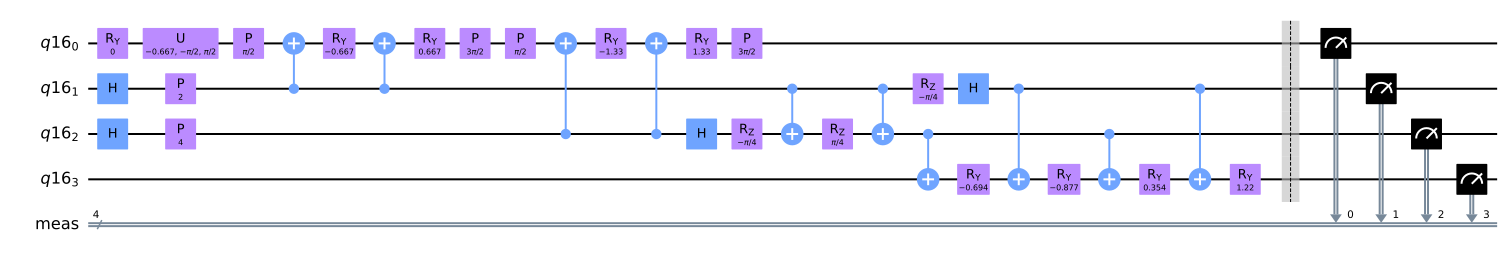

In [8]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np

t = 2  # This is not optimal; As an exercise, set this to the
       # value that will get the best results. See section 8 for solution.

nqubits = 4  # Total number of qubits
nb = 1  # Number of qubits representing the solution
nl = 2  # Number of qubits representing the eigenvalues

theta = 0  # Angle defining |b>

a = 1  # Matrix diagonal
b = -1/3  # Matrix off-diagonal

# Initialise the quantum and classical registers
qr = QuantumRegister(nqubits)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# State preparation. 
qc.ry(2*theta, qrb[0])
    
# QPE with e^{iAt}
for qu in qrl:
    qc.h(qu)

qc.p(a*t, qrl[0])
qc.p(a*t*2, qrl[1])

qc.u(b*t, -np.pi/2, np.pi/2, qrb[0])


# Controlled e^{iAt} on \lambda_{1}:
params=b*t

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Controlled e^{2iAt} on \lambda_{2}:
params = b*t*2

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Inverse QFT
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

# Eigenvalue rotation
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4

qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])
qc.measure_all()

print("Depth: %i" % qc.depth())
print("CNOTS: %i" % qc.count_ops()['cx'])
qc.draw(fold=-1)

The code below takes as inputs our circuit, the real hardware backend and the set of qubits we want to use, and returns and instance that can be run on the specified device. Creating the circuits with $3$ and $5$ CNOTs is the same but calling the transpile method with the right quantum circuit.

Real hardware devices need to be recalibrated regularly, and the fidelity of a specific qubit or gate can change over time. Furthermore, different chips have different connectivities. If we try to run a circuit that performs a two-qubit gate between two qubits that are not connected on the specified device, the transpiler will add SWAP gates. Therefore it is good practice to check with the IBM Quantum Experience webpage<sup>[[7]](#qexperience)</sup> before running the following code and choose a set of qubits with the right connectivity and lowest error rates at the given time.

In [9]:
from qiskit import execute, BasicAer, ClassicalRegister, IBMQ
from qiskit.compiler import transpile
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, # Measurement error mitigation functions
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)

provider = IBMQ.load_account()

backend = provider.get_backend('ibmqx2') # calibrate using real hardware
layout = [2,3,0,4]
chip_qubits = 5

# Transpiled circuit for the real hardware
qc_qa_cx = transpile(qc, backend=backend, initial_layout=layout)

The next step is to create the extra circuits used to mitigate the readout errors<sup>[[3]](#readouterr)</sup>.

In [ ]:
meas_cals, state_labels = complete_meas_cal(qubit_list=layout, qr=QuantumRegister(chip_qubits))
qcs = meas_cals + [qc_qa_cx]

qobj = assemble(qcs, shots=10)
job = backend.run(qobj)

The following plot<sup>[[5]](#tridi)</sup>, shows the results from running the circuit above on real hardware for $10$ different initial states. The $x$-axis represents the angle $\theta$ defining the initial state in each case. The results where obtained after mitigating the readout error and then extrapolating the errors arising during the run of the circuit from the results with the circuits with $1$, $3$ and $5$ CNOTs. 

<img src="images/norm_public.png">

Compare to the results without error mitigation nor extrapolation from the CNOTs<sup>[5](#tridi)</sup>.

<img src="images/noerrmit_public.png">

## 8. Problems<a id='problems'></a>

1. Run the algorithm 'evo_time': $2\pi(3/8)$. The fidelity should now be $1$.

##### Real hardware:

1. Set the time parameter for the optimised example.

<details>
    <summary> Solution (Click to expand)</summary>
    t = 2.344915690192344

The best result is to set it so that the smallest eigenvalue can be represented exactly, since it's inverse will have the largest contribution in the solution
</details>

2. Create transpiled circuits for $3$ and $5$ CNOTs from a given circuit 'qc'. When creating the circuits you will have to add barriers so that these consecutive CNOT gates do not get cancelled when using the transpile() method.
3. Run your circuits on the real hardware and apply a quadratic fit to the results to obtain the extrapolated value.

## 9. References<a id='references'></a>

1. J. R. Shewchuk. An Introduction to the Conjugate Gradient Method Without the Agonizing Pain. Technical Report CMU-CS-94-125, School of Computer Science, Carnegie Mellon University, Pittsburgh, Pennsylvania, March 1994.<a id='conjgrad'></a> 
2. A. W. Harrow, A. Hassidim, and S. Lloyd, “Quantum algorithm for linear systems of equations,” Phys. Rev. Lett. 103.15 (2009), p. 150502.<a id='hhl'></a>
3. A. Dewes, F. R. Ong, V. Schmitt, R. Lauro, N. Boulant, P. Bertet, D. Vion, and D. Esteve, “Characterization of a two-transmon processor with individual single-shot qubit readout,” Phys. Rev. Lett. 108, 057002 (2012). <a id='readouterr'></a>
4. N. Stamatopoulos, D. J. Egger, Y. Sun, C. Zoufal, R. Iten, N. Shen, and S. Woerner, “Option Pricing using Quantum Computers,” arXiv:1905.02666 . <a id='richardson'></a>
5. A. Carrera Vazquez, A. Frisch, D. Steenken, H. S. Barowski, R. Hiptmair, and S. Woerner, “Enhancing Quantum Linear System Algorithm by Richardson Extrapolation,” (to be included).<a id='tridi'></a>
6. R. Iten, O. Reardon-Smith, L. Mondada, E. Redmond, R. Singh Kohli, R. Colbeck, “Introduction to UniversalQCompiler,” arXiv:1904.01072 .<a id='qcompiler'></a>
7. https://quantum-computing.ibm.com/ .<a id='qexperience'></a>
8. D. Bucher, J. Mueggenburg, G. Kus, I. Haide, S. Deutschle, H. Barowski, D. Steenken, A. Frisch, "Qiskit Aqua: Solving linear systems of equations with the HHL algorithm" https://github.com/Qiskit/qiskit-tutorials/blob/master/legacy_tutorials/aqua/linear_systems_of_equations.ipynb